# Computer Vision 2023 Assignment 2: Image matching and retrieval

In this prac, you will experiment with image feature detectors, descriptors and matching. There are 3 main parts to the prac:

- matching an object in a pair of images
- searching for an object in a collection of images
- analysis and discussion of results

## General instructions

As before, you will use this notebook to run your code and display your results and analysis. Again we will mark a PDF conversion of your notebook, referring to your code if necessary, so you should ensure your code output is formatted neatly. 

***When converting to PDF, include the outputs and analysis only, not your code.*** You can do this from the command line using the `nbconvert` command (installed as part of Jupyter) as follows:

    jupyter nbconvert Assignment2.ipynb --to pdf --no-input --TagRemovePreprocessor.remove_cell_tags 'remove-cell'

This will also remove the preamble text from each question. It has been packaged into a small notebook you can run in colab, called notebooktopdf.ipynb


We will use the `OpenCV` library to complete the prac. It has several built in functions that will be useful. You are expected to consult documentation and use them appropriately.

As with the last assignment it is somewhat up to you how you answer each question. Ensure that the outputs and report are clear and easy to read so that the markers can rapidly assess what you have done, why, and how deep is your understanding. This includes:

- sizing, arranging and captioning image outputs appropriately
- explaining what you have done clearly and concisely
- clearly separating answers to each question

## Data

We have provided some example images for this assignment, available through a link on the MyUni assignment page. The images are organised by subject matter, with one folder containing images of book covers, one of museum exhibits, and another of urban landmarks. You should copy these data into a directory A2_smvs, keeping the directory structure the same as in the zip file.  

Within each category (within each folder), there is a “Reference” folder containing a clean image of each object and a “Query” folder containing images taken on a mobile device. Within each category, images with the same name contain the same object (so 001.jpg in the Reference folder contains the same book as 001.jpg in the Query folder).
The data is a subset of the Stanford Mobile Visual Search Dataset which is available at 

<http://web.cs.wpi.edu/~claypool/mmsys-dataset/2011/stanford/index.html>. 

The full data set contains more image categories and more query images of the objects we have provided, which may be useful for your testing!

Do not submit your own copy of the data or rename any files or folders! For marking, we will assume the datasets are available in subfolders of the working directory using the same folder names provided.

Here is some general setup code, which you can edit to suit your needs.

In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

In [2]:
# !pwd
# %cd drive/MyDrive/Colab\ Notebooks
# !pwd

In [3]:
# Numpy is the main package for scientific computing with Python. 
import numpy as np
import cv2

# Matplotlib is a useful plotting library for python 
import matplotlib.pyplot as plt
# This code is to make matplotlib figures appear inline in the
# notebook rather than in a new window.
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots, can be changed
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

In [4]:
def draw_outline(ref, query, model):
    """
        Draw outline of reference image in the query image.
        This is just an example to show the steps involved.
        You can modify to suit your needs.
        Inputs:
            ref: reference image
            query: query image
            model: estimated transformation from query to reference image
    """
    h,w = ref.shape[:2]
    pts = np.float32([ [0,0],[0,h-1],[w-1,h-1],[w-1,0] ]).reshape(-1,1,2)
    dst = cv2.perspectiveTransform(pts,model)
    
    img = query.copy()
    img = cv2.polylines(img,[np.int32(dst)],True,255,3, cv2.LINE_AA)
    plt.imshow(img, 'gray'), plt.show()

def draw_inliers(img1, img2, kp1, kp2, matches, matchesMask):
    """
        Draw inlier between images
        img1 / img2: reference/query  img
        kp1 / kp2: their keypoints
        matches : list of (good) matches after ratio test
        matchesMask: Inlier mask returned in cv2.findHomography() 
    """
    matchesMask = matchesMask.ravel().tolist()
    draw_params = dict(matchColor = (0,255,0), # draw matches in green color
                    singlePointColor = None,
                    matchesMask = matchesMask, # draw only inliers
                    flags = 2)
    img3 = cv2.drawMatches(img1,kp1,img2,kp2,matches,None,**draw_params)
    plt.imshow(img3, 'gray'),plt.show()


# Question 1: Matching an object in a pair of images (60%)


In this question, the aim is to accurately locate a reference object in a query image, for example:

![Books](book.png "Books")

0. Download and read through the paper [ORB: an efficient alternative to SIFT or SURF](https://www.researchgate.net/publication/221111151_ORB_an_efficient_alternative_to_SIFT_or_SURF) by Rublee et al. You don't need to understand all the details, but try to get an idea of how it works. ORB combines the FAST corner detector (covered in week 3) and the BRIEF descriptor. BRIEF is based on similar ideas to the SIFT descriptor we covered week 3, but with some changes for efficiency.

1. [Load images] Load the first (reference, query) image pair from the "book_covers" category using opencv (e.g. `img=cv2.imread()`). Check the parameter option in "
cv2.imread()" to ensure that you read the gray scale image, since it is necessary for computing ORB features.

2. [Detect features] Create opencv ORB feature extractor by `orb=cv2.ORB_create()`. Then you can detect keypoints by `kp = orb.detect(img,None)`, and compute descriptors by `kp, des = orb.compute(img, kp)`. You need to do this for each image, and then you can use `cv2.drawKeypoints()` for visualization.

3. [Match features] As ORB is a binary feature, you need to use HAMMING distance for matching, e.g., `bf = cv2.BFMatcher(cv2.NORM_HAMMING)`. Then you are requried to do KNN matching (k=2) by using `bf.knnMatch()`. After that, you are required to use "ratio_test" to find good matches. By default, you can set `ratio=0.8`.

4. [Plot and analyze] You need to visualize the matches by using the `cv2.drawMatches()` function. Also you can change the ratio values, parameters in `cv2.ORB_create()`, and distance functions in `cv2.BFMatcher()`. Please discuss how these changes influence the match numbers.


In [5]:
# load images as grey scale
from matplotlib import pyplot as plt
img1 = cv2.imread('a2/A2_smvs/book_covers/Reference/001.jpg', 0)

if not np.shape(img1):
  # Error message and print current working dir
  print("Could not load img1. Check the path, filename and current working directory\n")
  !pwd
img2 = cv2.imread("a2/A2_smvs/book_covers/Query/001.jpg", 0)
if not np.shape(img2):
  # Error message and print current working dir
  print("Could not load img2. Check the path, filename and current working directory\n")
  !pwd

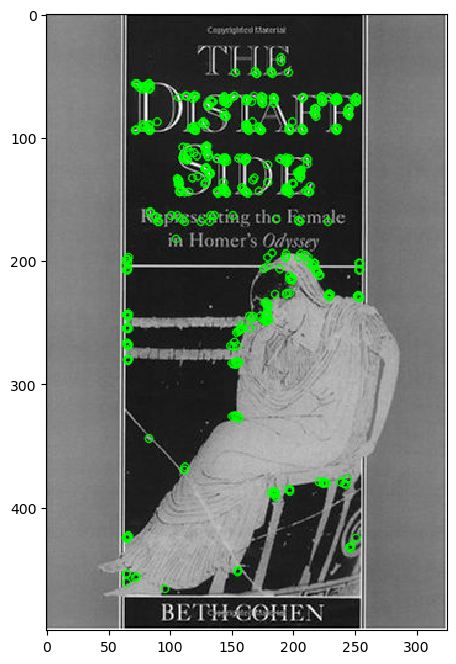

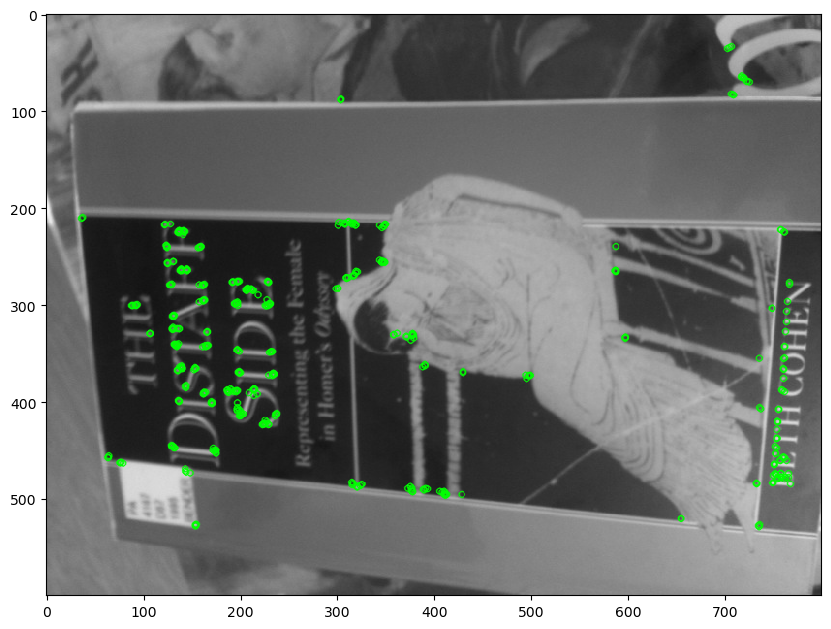

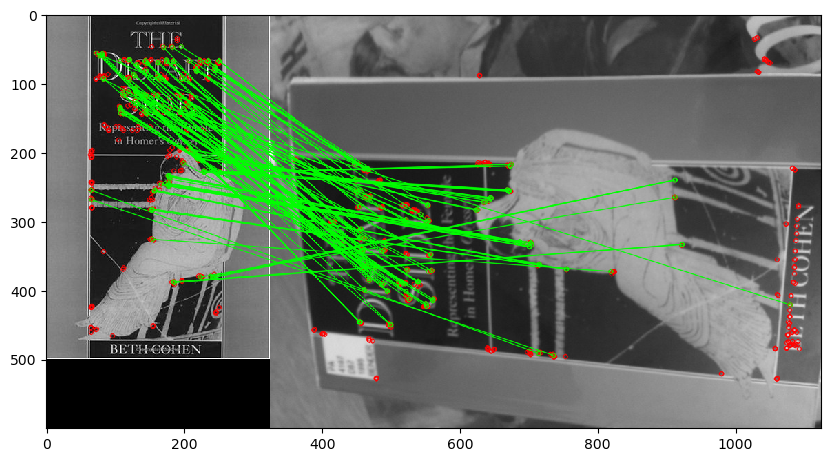

In [6]:
# Your code for descriptor matching tests here

#Changing nfeatures
#orb=cv2.ORB_create(nfeatures=10)
#Changing ratio 
# ratio1 = 0.2
# ratio2 = 1.5

# compute detector and descriptor, see (2) above
orb=cv2.ORB_create()

# find the keypoints and descriptors with ORB, see (2) above
kp1= orb.detect(img1, None)
kp2 = orb.detect(img2, None)

kp1, des1 = orb.compute(img1, kp1)
kp2, des2 = orb.compute(img2, kp2)

# draw keypoints, see (2) above
img1_kp = cv2.drawKeypoints(img1, kp1, None, color=(0,255,0), flags=0)
img2_kp = cv2.drawKeypoints(img2, kp2, None, color=(0,255,0), flags=0)

# create BFMatcher object, see (3) above
bf = cv2.BFMatcher(cv2.NORM_HAMMING)

# Match descriptors, see (3) above
matches = bf.knnMatch(des1, des2, k=2)

# Apply ratio test, see (3) above
good = []
ratio = 0.8
for m,n in matches:
    if m.distance < ratio * n.distance:
        good.append(m)

# draw matches, see (4) above
img_m = cv2.drawMatches(img1, kp1, img2, kp2, good, None,
                  matchColor = (0,255,0),
                  singlePointColor = (255,0,0))

#Displaying detected image 1 
plt.imshow(img1_kp)
plt.show()
#Displaying detected image 2
plt.imshow(img2_kp)
plt.show()
#Displaying matches
plt.imshow(img_m)
plt.show()


***Your explanation of what you have done, and your results, here***

Starting by implementing "orb=cv2.ORB_create()", the report uses Oriented FAST and Rotated BRIEF algorithm to detect keypoints and compute descriptors for each image where keypoint represents distinct,scale and rotate invariant point on images and descriptors contain information about neighbourhood of each point, similar to SIFT. Some of ORB_create()'s parameter are 'nfeatures' - maximum of features to retain, 'scaleFactor' - pyramid scale factor and 'nlevels' - size of pyramid level, thus changing these factor could affect quantity and quality of detected points, for example by changing nfeatures to 10, it directly limit the number of detection to 10. By leaving the parameter empty, it is expected to return all possible point using default setting.

After dectecting all keypoints and descriptors then visualize them through "cv2.drawKeypoints()", "cv2.BFMatcher(cv2.NORM_HAMMING)" is implied to create a brute force matcher using Hamming distance as the distance measurement. By default, without specifying the parameter with "cv2.NORM_HAMMING", cv2.NORM_L2 will be used which is less efficient in this case as L2 distance is euclidean distance taht provides more false negative for binary descriptors. The other parameter is 'crossCheck' which is used for returning only best matches that will conflit with KNN Matching and the proccess of finding good matches later on, thus it is set by default as False. 

Finaly, after implementing KNN matching through "bf.knnMatch()", the report have filtered out good matches using given ratio. The ratio_test regards the comparision between the best match's distance - "m.distance" with the distance of second best match or "n.distance". Thus, high ratio tends to provide more matches but low in quality while lower ration provide less matches but higher in quality as it filter out matches that are not significantly better. 

3. Estimate a homography transformation based on the matches, using `cv2.findHomography()`. Display the transformed outline of the first reference book cover image on the query image, to see how well they match.

    - We provide a function `draw_outline()` to help with the display, but you may need to edit it for your needs.
    - Try the 'least squre method' option to compute homography, and visualize the inliers by using `cv2.drawMatches()`. Explain your results.
    - Again, you don't need to compare results numerically at this stage. Comment on what you observe visually.

With Least-Median of squares robust method 


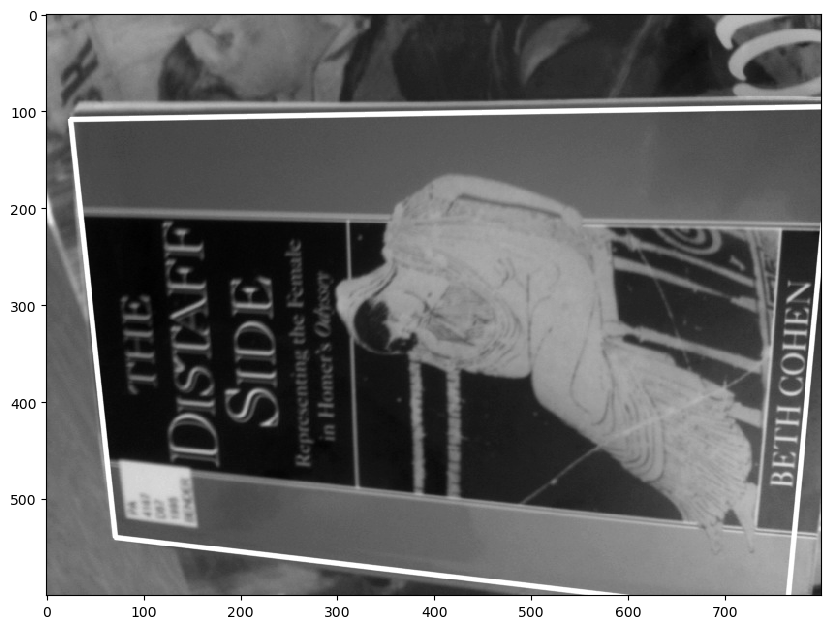

With Least Square Method


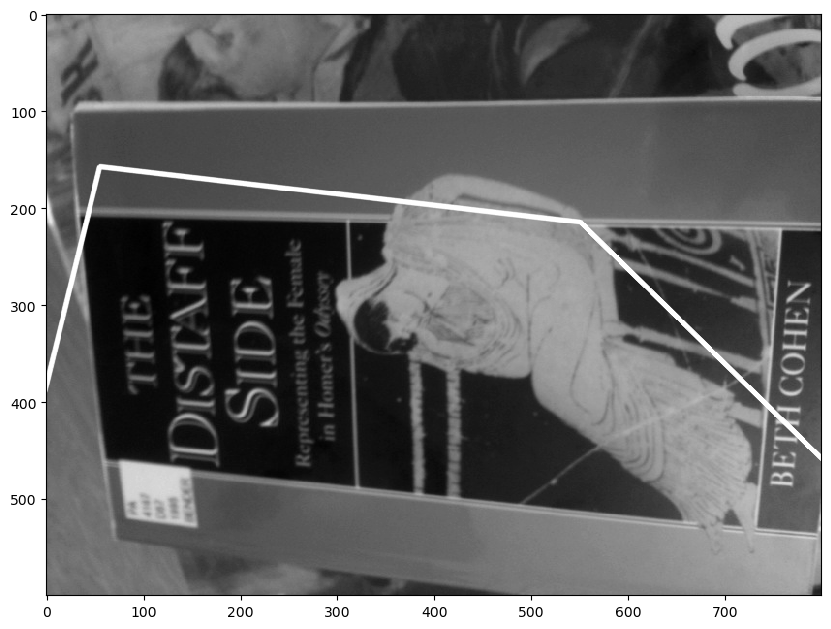

With Least-Median of squares robust method 


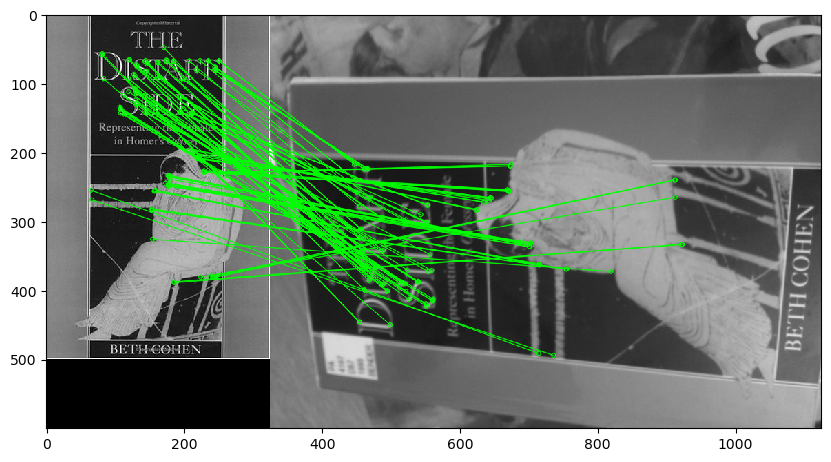

With Least Square Method


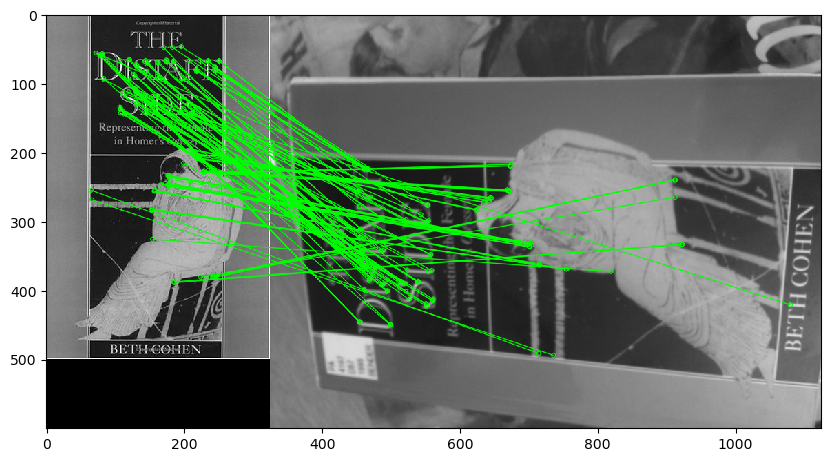

In [7]:
# Create src_pts and dst_pts as float arrays to be passed into cv2.,findHomography
src_pts = np.float32([kp1[m.queryIdx].pt for m in good]).reshape(-1,1,2)
dst_pts = np.float32([kp2[m.trainIdx].pt for m in good]).reshape(-1,1,2)

# using cv2 standard method, see (3) above

# Least-Median of squares robust method
Mz, maskz = cv2.findHomography(src_pts, dst_pts,cv2.LMEDS)
# Least square method
M, mask = cv2.findHomography(src_pts, dst_pts,method = 0)

# draw frame
print("With Least-Median of squares robust method ")
draw_outline(img1, img2, Mz)  #Least-Median of squares robust method
print("With Least Square Method") 
draw_outline(img1, img2, M) #least square method

# draw inliers
print("With Least-Median of squares robust method ") 
draw_inliers(img1, img2, kp1, kp2, good, maskz) #least square method
print("With Least Square Method") 
draw_inliers(img1, img2, kp1, kp2, good, mask)



***Your explanation of results here***

By setting "method = 0" inside the parameter of "findHomography()", it implies the method of Least Square while "cv2.LMEDS" enable Least-Median of squares robust method. Visually, the two method provide almost identical inliners with Least Square Method provides some extra point while there is a different in the present of outlier as Least-Median method provide a more fit outlier. 


Try the RANSAC option to compute homography. Change the RANSAC parameters, and explain your results. Print and analyze the inlier numbers.

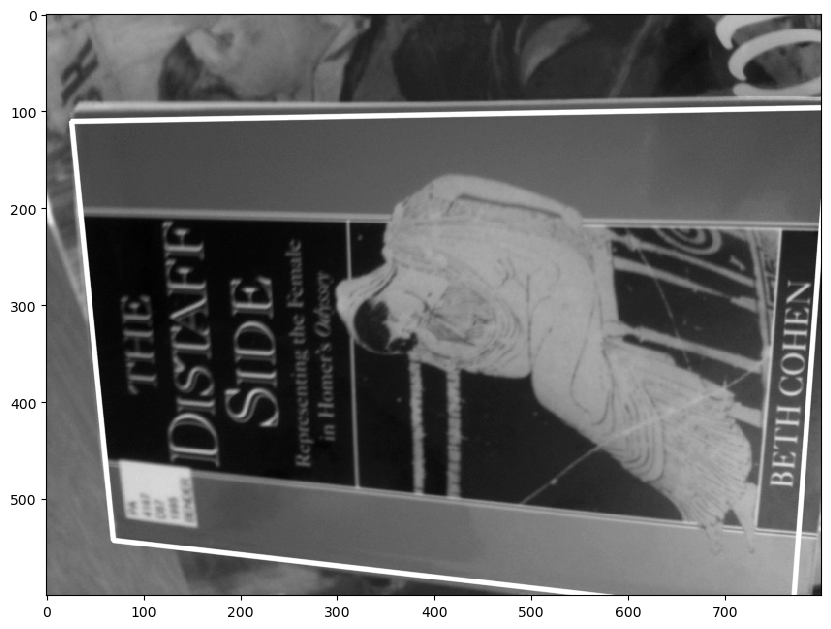

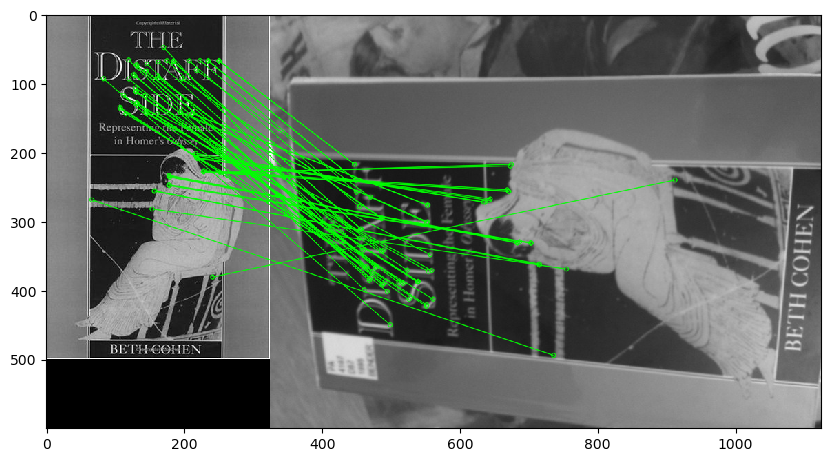

The number of inliers is: 64


RANSAC with threshold of 9


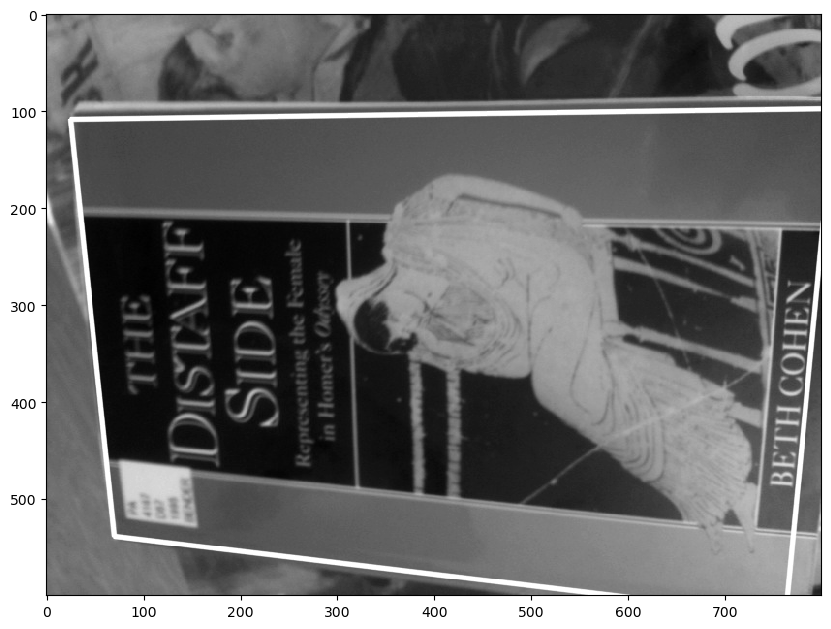

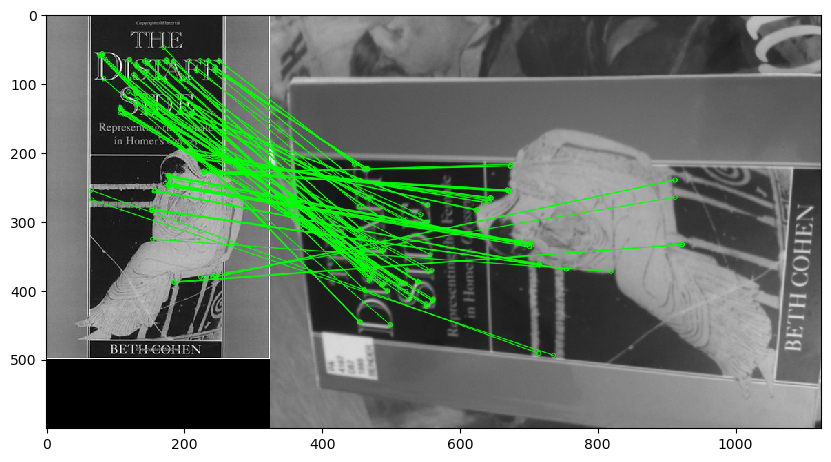

The number of inliers is: 116


In [8]:
# Your code to display book location after RANSAC here

# using RANSAC
M1, mask1 = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 2.0)
# draw frame
draw_outline(img1, img2, M1)

# draw inliers
draw_inliers(img1, img2, kp1, kp2, good, mask1)

# inlier number
inlier = 0
#print(mask1)
for i in mask1:
     if i == 1:
         inlier += 1
print("The number of inliers is:",inlier)

# using RANSAC - 10
print("\n")
print("RANSAC with threshold of 9")
M1b, mask1b = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 9.0)
draw_outline(img1, img2, M1b)
draw_inliers(img1, img2, kp1, kp2, good, mask1b)
inlier = 0
#print(mask1)
for i in mask1b:
     if i == 1:
         inlier += 1
print("The number of inliers is:",inlier)

***Your explanation of what you have tried, and results here***

"findHomography()" takes in coordinates of points in the original and target plan as its first parameter. Then by specifying the method, it apply the chosen method for computing homography matrix. By setting the method to "cv.RANSAC", RansacReprojThreshold or maximum allowed reprojection error to treat a point pair as an inlier, is set by default of 3.0. I've tried to change this number and have noticed some change. As the threshold reduce, it also reduce the number of inliers as it requires the pairs to have less reprojections which means more exact required. Similarly, increasing the threshold closer to 10.0, also witness the increase in the number of inliers. For example, the number of inliers increase from 64 to 116 as we're increasing the threshold from 2.0 to 9.0. 

6. Finally, try matching several different image pairs from the data provided, including at least one success and one failure case. For the failure case, test and explain what step in the feature matching has failed, and try to improve it. Display and discuss your findings.
    1. Hint 1: In general, the book covers should be the easiest to match, while the landmarks are the hardest.
    2. Hint 2: Explain why you chose each example shown, and what parameter settings were used.
    3. Hint 3: Possible failure points include the feature detector, the feature descriptor, the matching strategy, or a combination of these.

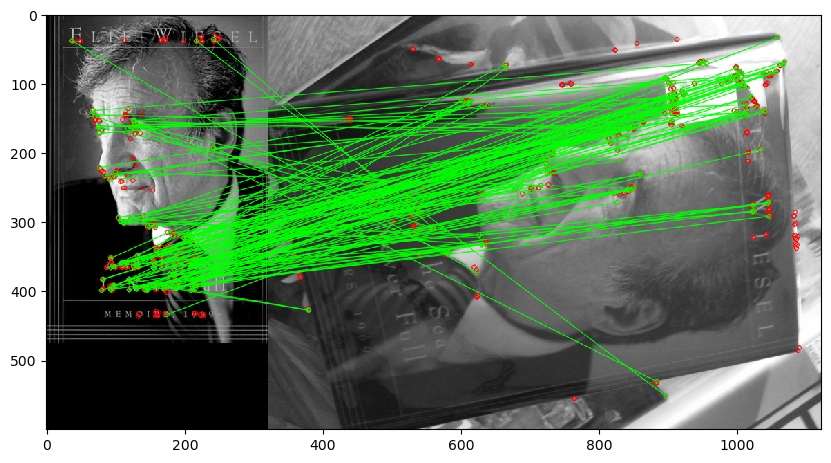

Using Ransac


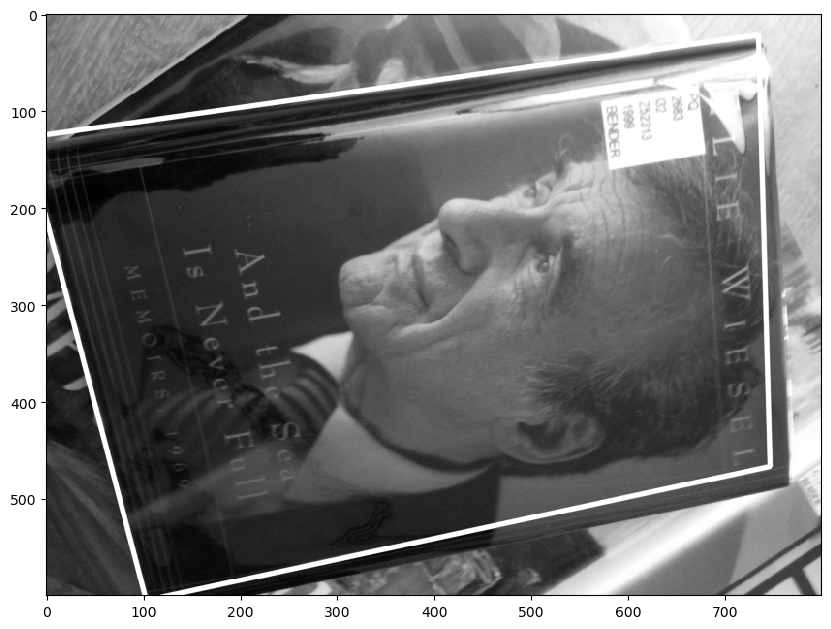

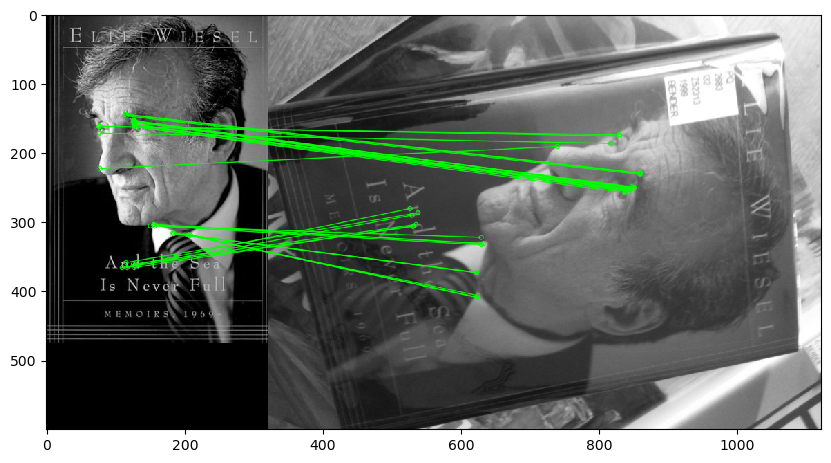

The number of inliers is: 36

LANDMARK


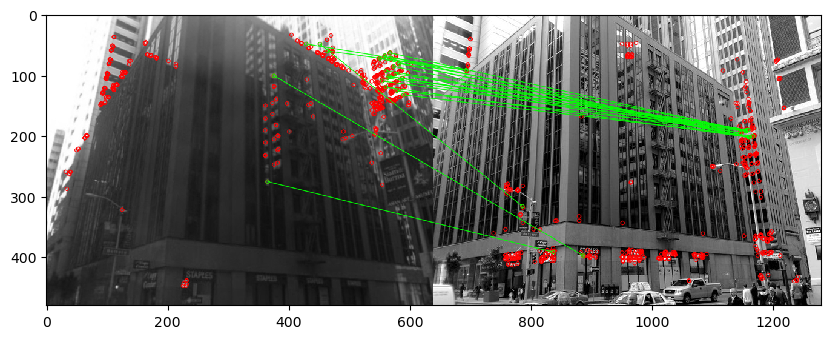

Using Ransac


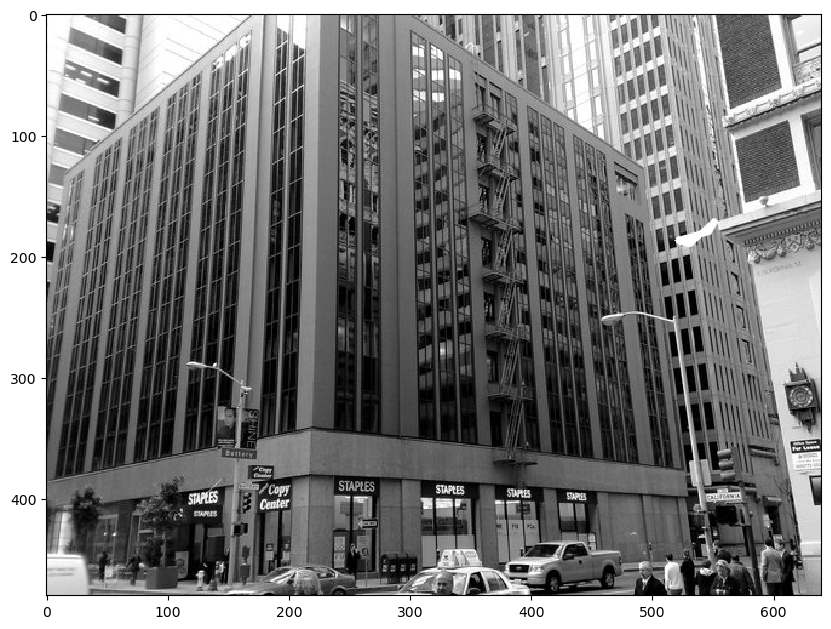

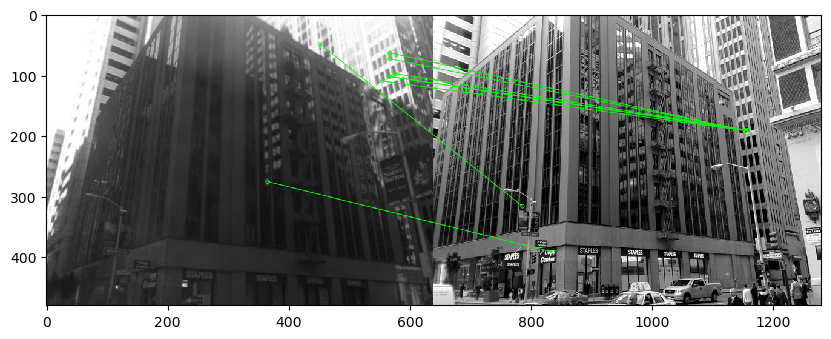

The number of inliers is: 8


In [9]:
# Your results for other image pairs here
# Starting with picture 10 
img3 = cv2.imread('a2/A2_smvs/book_covers/Reference/004.jpg', 0)
img4 = cv2.imread('a2/A2_smvs/book_covers/Query/004.jpg', 0)

kp3= orb.detect(img3, None)
kp4 = orb.detect(img4, None)

kp3, des3 = orb.compute(img3, kp3)
kp4, des4 = orb.compute(img4, kp4)

matches1 = bf.knnMatch(des3, des4, k=2)

good1 = []
ratio = 0.8
for m,n in matches1:
    if m.distance < ratio * n.distance:
        good1.append(m)
        
img_m1 = cv2.drawMatches(img3, kp3, img4, kp4, good, None,
                  matchColor = (0,255,0),
                  singlePointColor = (255,0,0))

plt.imshow(img_m1)
plt.show()
print("Using Ransac")
src_pts1 = np.float32([kp3[m.queryIdx].pt for m in good1]).reshape(-1,1,2)
dst_pts1 = np.float32([kp4[m.trainIdx].pt for m in good1]).reshape(-1,1,2)
M2, mask2 = cv2.findHomography(src_pts1, dst_pts1,cv2.RANSAC, 9.0)
draw_outline(img3, img4, M2)
draw_inliers(img3, img4, kp3, kp4, good1, mask2)
# inlier number
inlier = 0
#print(mask2)
for i in mask2:
     if i == 1:
         inlier += 1
print("The number of inliers is:",inlier)


#######LANDMARK 
print("\nLANDMARK")
img5 = cv2.imread('a2/A2_smvs/landmarks/Reference/042.jpg', 0)
img6 = cv2.imread('a2/A2_smvs/landmarks/Query/042.jpg', 0)

kp5= orb.detect(img5, None)
kp6 = orb.detect(img6, None)

kp5, des5 = orb.compute(img5, kp5)
kp6, des6 = orb.compute(img6, kp6)

matches2 = bf.knnMatch(des5, des6, k=2)

good2 = []
ratio = 0.8
for m,n in matches2:
    if m.distance < ratio * n.distance:
        good2.append(m)
        
img_m2 = cv2.drawMatches(img5, kp5, img6, kp6, good2, None,
                  matchColor = (0,255,0),
                  singlePointColor = (255,0,0))

plt.imshow(img_m2)
plt.show()
print("Using Ransac")
src_pts2 = np.float32([kp5[m.queryIdx].pt for m in good2]).reshape(-1,1,2)
dst_pts2 = np.float32([kp6[m.trainIdx].pt for m in good2]).reshape(-1,1,2)
M3, mask3 = cv2.findHomography(src_pts2, dst_pts2,cv2.RANSAC, 2.0)
draw_outline(img5, img6, M3)
draw_inliers(img5, img6, kp5, kp6, good2, mask3)
# inlier number
inlier = 0
#print(mask2)
for i in mask3:
     if i == 1:
         inlier += 1
print("The number of inliers is:",inlier)

***Your explanation of results here***

For both test i've kept the good matches ratio to be 0.8 as well as 5.0 threshold for RANSAC method. Good matches's ratio is retained from the previous question as the ratio ensure a fair number of matches while also to catch "good enough" pair. Beside that, keeping a consant ratio will also help me to make comparisions between book covers images and landmarks easier that help evaluate its efficiency. In the other hand, due to picking nearly extreme thresholds for testing in the previous part, within this part i want to pick a more "balance" threshold of 0.5 in order to obtain a good amount of matches but still expect a good quality from these matches. 

SUCCESSFULL CASE:

SET UP: For the first pair of images, i've chosen the image of a book cover with a human depicted on it as the reference image, and another image from query that showing the book upside down. This is because book's cover with human's images and a large label provides ranges of different textures, pattern and could provide some challenges for matching, especially when the query image is rotated. However, given that book cover contains distinct visual elements and less affected by light's condition or roration, it is also expected to have multiple inliners as well as good matches. 

After matching proccess, the algorithm performed well overall, as it have identified multiple quality keypoints that are particularly distinct and present a unique feature. However, in regions containing name of the book, there were instances of incorrect matches due to the blurring pixel and position of these characters. Despite this, the alogrithm still provide a good overview matches. 

To improve the accuracy of matching, I adjusted the RANSAC threshold to 9.0 which resulted in the detection of additional true positive matches in the image. While getting additional false negative but it is considered acceptable 

FAILURE CASE:

SET UP: The second pair of images depicts the corner of a building covered by glass windows. As glass windows create reflection depending on light source and there is a different in time,camera and angle of the two, these images pose a significant challenge for feature matching due their unconsistent and non distinctive nature. As result, it might not be distinctive enough for the algorithm  to accurately detect and match keypoints. In addition, "false images" of other building causes by reflection within these pictures could potentially lead to the mismatch and confusion within ORB algorithm
After matching proccess, the algorithm are able to identify multiple keypoints however as i've concerned, most of the detected keypoint belongs to the reflective images of other building through glass rather than the main building itself. Despite having some good keypoints along the edge of the  building, the matches was fail between multiple points as well as wrong matches for example some higher windows was matching with lower windows that're not share the same column. 

Feature detector identifies distinctive points or keypoints in the images, reflection and low contrast cause detecting keypoints to be difficult as the alogrithm confuses to distinct pixels. Similarly, light, viewpoint and reflection also affect feature descriptor as after keypoints are detected, the descriptor extracts information to represent their local appearance. To improve the accuracy of matching, I attempted to reduce the threshold fir RANSAC used in the matching process to 2.0 which result in eliminating additional false positive from the inliners (Number of inliners reduce from 10 to 8). Thus, by reducing the threshold the accuracy of matching increase. 






# Question 2: What am I looking at? (40%)


<!--One application of feature matching is image retrieval. The goal of image retrieval is, given a query image of an object, to find all images in a database containing the same object, and return the results in ranked order (like a Google search). This is a huge research area but we will implement a very basic version of the problem based on the small dataset provided.-->

In this question, the aim is to identify an "unknown" object depicted in a query image, by matching it to multiple reference images, and selecting the highest scoring match. Since we only have one reference image per object, there is at most one correct answer. This is useful for example if you want to automatically identify a book from a picture of its cover, or a painting or a geographic location from an unlabelled photograph of it.

The steps are as follows:

1. Select a set of reference images and their corresponding query images. 

    1. Hint 1: Start with the book covers, or just a subset of them.
    3. Hing 2: This question can require a lot of computation to run from start to finish, so cache intermediate results (e.g. feature descriptors) where you can.
    
2. Choose one query image corresponding to one of your reference images. Use RANSAC to match your query image to each reference image, and count the number of inlier matches found in each case. This will be the matching score for that image.

3. Identify the query object. This is the identity of the reference image with the highest match score, or "not in dataset" if the maximum score is below a threshold.

4. Repeat steps 2-3 for every query image and report the overall accuracy of your method (that is, the percentage of query images that were correctly matched in the dataset). Discussion of results should include both overall accuracy and individual failure cases.

    1. Hint 1: In case of failure, what ranking did the actual match receive? If we used a "top-k" accuracy measure, where a match is considered correct if it appears in the top k match scores, would that change the result?

<!--Code to implement this algorithm should mostly be written in a supporting file such as a2code.py. Call your code and display outputs in the notebook below.--> 


In [10]:
# This cell using to test and import set of reference and query 
img_ref = []
ref_folder = 'a2/A2_smvs/book_covers/Reference/'
ref_names = []
# Taking the first 40 image
for i in range(1, 41):
    ref_names.append(ref_folder + "{:03d}.jpg".format(i))

for n in ref_names:
    img = cv2.imread(n, 0)
    img_ref.append(img)

# Indexing from 0 -> 38
# plt.imshow(img_ref[3])
# plt.show()

img_que = []
que_folder = 'a2/A2_smvs/book_covers/Query/'
que_names = []
# Taking the first 15 image
for i in range(1, 41):
    que_names.append(que_folder + "{:03d}.jpg".format(i))

for n in que_names:
    img = cv2.imread(n, 0)
    img_que.append(img)



In [11]:
# Your code to iddntify query objects and measure search accuracy for data set here 
#Using img_b2 to match every images in img_b1
chosen_img_ref = cv2.imread('a2/A2_smvs/book_covers/Reference/009.jpg', 0)
chosen_img_que = cv2.imread('a2/A2_smvs/book_covers/Query/009.jpg', 0)



def matching_score(img_ref,img_que):

    kpr= orb.detect(img_ref, None)
    kpq = orb.detect(img_que, None)
    
    kpr, desr = orb.compute(img_ref, kpr)
    kpq, desq = orb.compute(img_que, kpq)
    
    matches_q2 = bf.knnMatch(desr, desq, k=2)
    good_q2 = []
    #Using old ratio of 0.8
    for m,n in matches_q2:
        if m.distance < ratio * n.distance:
            good_q2.append(m)
            
    if len(good_q2) < 4:
       
        return 0
        
    src_pts_q2 = np.float32([kpr[m.queryIdx].pt for m in good_q2]).reshape(-1,1,2)
    dst_pts_q2 = np.float32([kpq[m.trainIdx].pt for m in good_q2]).reshape(-1,1,2)
    M_q2, mask_q2 = cv2.findHomography(src_pts_q2, dst_pts_q2, cv2.RANSAC, 5.0)
    matching_score = int(sum(mask_q2))
    #print(matching_score)
    score = matching_score
    return score

score = matching_score(chosen_img_ref,chosen_img_que)
best_index = -1
query_object = img_ref[0]

#Getting i iteration
for i,ref in enumerate(img_ref):
    best_score =  matching_score(ref,chosen_img_que)
    if best_score >= score:
       query_object = ref
       highest = best_score
       best_index = i
    
if highest < score:
    print("Not in dataset")
else:
    print(f"Query image - 009  matches Reference image - {best_index+1} with matching score - {highest}")
    print("End step 1->3, starting step 4")

# # Step 4
success = 0
for i1,que in enumerate(img_que):
    highest = 0
    
    for i2,ref in enumerate(img_ref):
        best_score =  matching_score(ref,que)
        #print(f"{i2} and {best_score}")
        if best_score >= highest:
           query_object = ref
           highest = best_score
           best_index = i2
    threshold = 20
    if highest < threshold:
        print(f"Not in dataset - Query image: {i1+1}")
    else:
        print(f"Query image - {i1+1}  matches Reference image - {best_index+1} with matching score - {highest}")
        success+=1

print(f"The accuracy is {round(success*100/40,2)}%")

Query image - 009  matches Reference image - 9 with matching score - 63
End step 1->3, starting step 4
Query image - 1  matches Reference image - 1 with matching score - 111
Query image - 2  matches Reference image - 2 with matching score - 64
Query image - 3  matches Reference image - 3 with matching score - 79
Query image - 4  matches Reference image - 4 with matching score - 30
Query image - 5  matches Reference image - 5 with matching score - 47
Query image - 6  matches Reference image - 6 with matching score - 94
Query image - 7  matches Reference image - 7 with matching score - 47
Not in dataset - Query image: 8
Query image - 9  matches Reference image - 9 with matching score - 63
Query image - 10  matches Reference image - 10 with matching score - 109
Query image - 11  matches Reference image - 11 with matching score - 84
Query image - 12  matches Reference image - 12 with matching score - 52
Query image - 13  matches Reference image - 13 with matching score - 62
Query image - 1

***Your explanation of what you have done, and your results, here***

Starting by creating subset of Query Image and their matching Reference Image. Then,Similar to the previous question, for the step 1->3, i've repeated the same proccess. Starting from choosing Reference and Query image 9 for testing out the number of inliers. Using ORB detector, i've detected keypoints  descriptors for both of the images while keeping the old ratio of 0.8 (As from previous question, i think 0.8 is a good ratio to obtain a fair amount of matches with good quality). I've also used brute force matcher that specify Hamming distance to decide whether a match is a good match. Then RANSAC had been used to eliminate any outliers and obtaining inliers. Then by implying function "matching_score" that take in Reference image and Query image as parameters, i've successfully traversed the chosen query image - image 009 over the first 40 images and counting numbers of inliers as matching score for each of them. Afterward, I've picked out the image with the highest matching score (or highest number of inliers) as the query object. NOTED: The code also eliminate any image with 4 or less good matches as it's not enough to run RANSAC and assign the matching score to be 0.

Moving to step 4, i picked the threshold matching score to be 20 as obtaining less than 20 inliers is considered unsuccessful match, aiming to balance between false positives and false negatives. After running the loop that match every query images with every reference images, then by counting success cases (higher than 20) i've achieved 90% of accuracy which is reasonable for identifying book covers's task. In cases of failure,the actual match receives the lowest possible ranking among all other matches which due to none of reference image achieve a high enough matching score to be considered successfull. Top-k accuracy measures could potentially affect the result but not by much. As method provides additional successful matches, it could increase the matching score slightly by considering these extra matches.  



5. Choose some extra query images of objects that do not occur in the reference dataset. Repeat step 4 with these images added to your query set. Accuracy is now measured by the percentage of query images correctly identified in the dataset, or correctly identified as not occurring in the dataset. Report how accuracy is altered by including these queries, and any changes you have made to improve performance.

In [12]:
# Starting by adding 5 extra query images 
img_e1 = cv2.imread('a2/A2_smvs/book_covers/Query/059.jpg', 0)
img_que.append(img_e1)
img_e2 = cv2.imread('a2/A2_smvs/book_covers/Query/099.jpg', 0)
img_que.append(img_e2)
img_e3 = cv2.imread('a2/A2_smvs/book_covers/Query/049.jpg', 0)
img_que.append(img_e3)
img_e4 = cv2.imread('a2/A2_smvs/book_covers/Query/092.jpg', 0)
img_que.append(img_e4)
img_e5 = cv2.imread('a2/A2_smvs/book_covers/Query/095.jpg', 0)
img_que.append(img_e5)

In [13]:
# Your code to run extra queries and display results here
# Repeating step 4

# # Step 4
extra_query_count = 5
correct = 0
for i1,que in enumerate(img_que):
    highest = 0
  
    for i2,ref in enumerate(img_ref):
        best_score =  matching_score(ref,que)
        #print(f"{i2} and {best_score}")
        
        if best_score >= highest:
           query_object = ref
           highest = best_score
           best_index = i2
    threshold = 20
    if highest < threshold:
        print(f"Not in dataset - Query image: {i1+1}")
    else:
        print(f"Query image - {i1+1}  matches Reference image - {best_index+1} with matching score - {highest}")
    
    # Start counting the extra 5
    if i1 >= 40:
        if highest < threshold:
            correct = correct + 1
    
    
print(f"Accuracy measured by correctly identified as not occurring in the dataset. {round(correct*100/extra_query_count,2)}%")

Query image - 1  matches Reference image - 1 with matching score - 111
Query image - 2  matches Reference image - 2 with matching score - 64
Query image - 3  matches Reference image - 3 with matching score - 79
Query image - 4  matches Reference image - 4 with matching score - 30
Query image - 5  matches Reference image - 5 with matching score - 47
Query image - 6  matches Reference image - 6 with matching score - 94
Query image - 7  matches Reference image - 7 with matching score - 47
Not in dataset - Query image: 8
Query image - 9  matches Reference image - 9 with matching score - 63
Query image - 10  matches Reference image - 10 with matching score - 109
Query image - 11  matches Reference image - 11 with matching score - 84
Query image - 12  matches Reference image - 12 with matching score - 52
Query image - 13  matches Reference image - 13 with matching score - 62
Query image - 14  matches Reference image - 14 with matching score - 65
Query image - 15  matches Reference image - 15

***Your explanation of results and any changes made here***

Starting step 5 by adding extra 5 images that does not have corresponding reference image in "ref_img" img, i discover that out 5 image, the program is able to identify 4 of them that does not in the dataset which achieve the accuracy of 80%. To improve this, i'd have to set a higher threshold (i've tried threshold of 25), however it's will also led to the increase of false negatives cases  where valid matches are incorrectly labeled as not in the dataset that reduce the accuracy calculated in step 4. 


6. Repeat step 4 and 5 for at least one other set of reference images from museum_paintings or landmarks, and compare the accuracy obtained. Analyse both your overall result and individual image matches to diagnose where problems are occurring, and what you could do to improve performance. Test at least one of your proposed improvements and report its effect on accuracy.


In [14]:
img_ref_m = []
ref_folder_m = 'a2/A2_smvs/museum_paintings/Reference/'
ref_names_m = []
# Taking the first 40 image
for i in range(1, 41):
    ref_names_m.append(ref_folder_m + "{:03d}.jpg".format(i))

for n in ref_names_m:
    img_m = cv2.imread(n, 0)
    img_ref_m.append(img_m)
    
img_que_m = []
que_folder_m = 'a2/A2_smvs/museum_paintings/Query/'
que_names_m = []
# Taking the first 15 image
for i in range(1, 41):
    que_names_m.append(que_folder_m + "{:03d}.jpg".format(i))

for n in que_names_m:
    img_m = cv2.imread(n, 0)
    img_que_m.append(img_m)

In [18]:
# Your code to search images and display results here
query_count = len(img_que_m)
correct = 0
for i1,que in enumerate(img_que_m):
    highest = 0
  
    for i2,ref in enumerate(img_ref_m):
        best_score =  matching_score(ref,que)
        #print(f"{i2} and {best_score}")
        
        if best_score >= highest:
           query_object = ref
           highest = best_score
           best_index = i2
    threshold = 20
    if highest < threshold:
        print(f"Not in dataset - Query image: {i1+1}")
    else:
        print(f"Query image - {i1+1}  matches Reference image - {best_index+1} with matching score - {highest}")
        correct = correct + 1
    # Start counting the extra 5
    if i1 >= 40:
        if highest < threshold:
            correct = correct + 1
    
    
print(f"The accuracy is {round(correct*100/40,2)}%")



Query image - 1  matches Reference image - 1 with matching score - 48
Not in dataset - Query image: 2
Not in dataset - Query image: 3
Not in dataset - Query image: 4
Not in dataset - Query image: 5
Query image - 6  matches Reference image - 6 with matching score - 22
Query image - 7  matches Reference image - 7 with matching score - 58
Query image - 8  matches Reference image - 8 with matching score - 126
Not in dataset - Query image: 9
Query image - 10  matches Reference image - 10 with matching score - 34
Query image - 11  matches Reference image - 11 with matching score - 31
Query image - 12  matches Reference image - 12 with matching score - 81
Not in dataset - Query image: 13
Query image - 14  matches Reference image - 14 with matching score - 36
Not in dataset - Query image: 15
Query image - 16  matches Reference image - 16 with matching score - 28
Query image - 17  matches Reference image - 17 with matching score - 107
Query image - 18  matches Reference image - 18 with matching

In [19]:
print("\nTesting with modified threshold")
for i1,que in enumerate(img_que_m):
    highest = 0
  
    for i2,ref in enumerate(img_ref_m):
        best_score =  matching_score(ref,que)
        #print(f"{i2} and {best_score}")
        
        if best_score >= highest:
           query_object = ref
           highest = best_score
           best_index = i2
    threshold = 18
    if highest < threshold:
        print(f"Not in dataset - Query image: {i1+1}")
    else:
        print(f"Query image - {i1+1}  matches Reference image - {best_index+1} with matching score - {highest}")
        correct = correct + 1
    # Start counting the extra 5
    if i1 >= 40:
        if highest < threshold:
            correct = correct + 1
print(f"The accuracy is {round(correct*100/40,2)}%")


Testing with modified threshold
Query image - 1  matches Reference image - 1 with matching score - 48
Not in dataset - Query image: 2
Not in dataset - Query image: 3
Not in dataset - Query image: 4
Not in dataset - Query image: 5
Query image - 6  matches Reference image - 6 with matching score - 22
Query image - 7  matches Reference image - 7 with matching score - 58
Query image - 8  matches Reference image - 8 with matching score - 126
Not in dataset - Query image: 9
Query image - 10  matches Reference image - 10 with matching score - 34
Query image - 11  matches Reference image - 11 with matching score - 31
Query image - 12  matches Reference image - 12 with matching score - 81
Not in dataset - Query image: 13
Query image - 14  matches Reference image - 14 with matching score - 36
Not in dataset - Query image: 15
Query image - 16  matches Reference image - 16 with matching score - 28
Query image - 17  matches Reference image - 17 with matching score - 107
Query image - 18  matches R

***Your description of what you have done, and explanation of results, here***

I repeat the same procedures for museum painting and getting the accuracy of 42.5% as result. This is significantly lower tahn the 90% accuracy achieved with the previous set of reference book covers images. Despite having some Query images matches Reference image, a significant number of query images were labeled as "Not in dataset", indicating that the algorithm failed to identify corresponding reference images for them. After going to more detail by asking the "Not in dataset" image to print its matching score, i observe potential issues with the matching algorithm's performance as museum painting or landmark(from previous question) are challenging objects for feature detector, descriptor as well as matching process due to their lack of distinct, unique keypoints. Thus, taking into account these challenges, i've decided to reduce the threshold from 20 to 18 for determining successfull matching, since the current threshold could be too high for "hard-for-matching" objects. By reducing the threshold by 2, i'd expect it to capture more matches without significantly increasing false positives. As result, after changing the threshold, the accuracy was jumping from 42.5% to 85% which show the effectiveness of threshold changing.